Bazirano na radu  :Conformal Prediction Intervals for Dynamic Time-Series [https://proceedings.mlr.press/v139/xu21h/xu21h.pdf]

Ensemble batch PIs (EnbPIs)


The study introduces a **technique** for creating PIs **not bound by** any specific **distribution** for **dynamic
time series dat**a. The EnbPI method encompasses a** bootstrap ensemble estimator to formulate sequential
P**Is. Unlike classical conformal prediction methods that require data exchangeability, EnbP**I does not
require data exchangeabil**ity and has been custom-built for time series.
The data exchangeability assumption suggests that the sequence in which observations appear in the
dataset doesn’t matter. However, this assumption does not apply to time series, where the sequence
of data points is crucial. EnbPI doesn’t rely on data exchangeability, making it aptly suited for time
series analysis.
PIs generated by EnbPI attain a finite-sample, approximately valid marginal coverage for broad
regression functions and time series under the mild assumption of strongly mixing stochastic errors.
Additionally, EnbPI is computationally efficient and avoids overfitting by not requiring data splitting or
training multiple ensemble estimators. It is also scalable to producing arbitrarily many PIs sequentially
and is well suited to a wide range of regression functions.
Time series data is dynamic and often non-stationary, meaning the statistical properties can change
over time. While various regression functions exist for predicting time series, such as those using
boosted trees or neural network structures, these existing methods often need help constructing
accurate PIs. Typically, they can only create reliable intervals by placing restrictive assumptions on
the underlying distribution of the time series, which may only sometimes be appropriate or feasible

In [314]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, normalize, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    HistGradientBoostingRegressor,
    RandomForestRegressor
)

from fortuna.conformal import (
    EnbPI,
    JackknifePlusConformalRegressor,
    JackknifeMinmaxConformalRegressor,
)

from fortuna.metric.regression import prediction_interval_coverage_probability

TODO: pogledati https://aws-fortuna.readthedocs.io/en/latest/examples/jackknifeplus_regression.html

## Učitavanje podataka 

- CITY HOTEL : Lisabon, Hotel ID 1
- RESORT HOTEL: Algarve, Hotel ID 0

In [239]:
DATA_HOTEL0_BASE_PATH = '../data/interim/hotel_0'
DATA_HOTEL1_BASE_PATH = '../data/interim/hotel_1'
WEATHER_DATA_BASE_PATH = '../data/external/weather_data'
HOLIDAYS_BASE_PATH = '../data/external/holidays'


In [240]:
city_weather = pd.read_csv(os.path.join(WEATHER_DATA_BASE_PATH, 'lisbon//lisbon_weather_data.csv'))
resort_weather = pd.read_csv(os.path.join(WEATHER_DATA_BASE_PATH, 'algarve//algarve_weather_data.csv'))

In [241]:
portugal_holidays = pd.read_csv(os.path.join(HOLIDAYS_BASE_PATH, 'portugal//holidays.csv'))

In [242]:
NumberOfGuestsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_guests.parquet"))
NumberOfArrivalsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_arrivals.parquet"))

In [243]:
NumberOfGuestsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_guests.parquet"))
NumberOfArrivalsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_arrivals.parquet"))

### Dnevni dolasci

#### Podaci na dnevnoj bazi City Hotel 

In [244]:
NumberOfArrivalsDailyCity = NumberOfArrivalsDailyCity.reset_index()

city_weather['datetime'] = pd.to_datetime(city_weather['datetime'], format='%Y-%m-%d')

daily_arrival_city_data = pd.merge(NumberOfArrivalsDailyCity, city_weather, left_on='datum_dolaska', right_on='datetime')


In [245]:
daily_arrival_city_data.drop(columns=['datetime','name','stations',], inplace=True)


In [246]:
portugal_holidays['date'] = pd.to_datetime(portugal_holidays['date'], format='%Y-%m-%d')
daily_arrival_city_data['datum_dolaska'] = pd.to_datetime(daily_arrival_city_data['datum_dolaska'])

daily_arrival_city_data = pd.merge(daily_arrival_city_data, portugal_holidays, left_on='datum_dolaska', right_on='date', how='left')
daily_arrival_city_data['holiday'] = daily_arrival_city_data['name'].notna()


In [247]:
daily_arrival_city_data['workingday'] = daily_arrival_city_data['datum_dolaska'].dt.dayofweek.isin(range(5)) & ~daily_arrival_city_data['holiday']


In [248]:
daily_arrival_city_data['year']  = daily_arrival_city_data['datum_dolaska'].dt.year
daily_arrival_city_data['month'] = daily_arrival_city_data['datum_dolaska'].dt.month
daily_arrival_city_data['day']   = daily_arrival_city_data['datum_dolaska'].dt.day

In [249]:
daily_arrival_city_data.drop(['date', 'name', 'type','severerisk','feelslikemax',
                      'feelslikemin','precipprob','precipcover',
                      'sunrise','sunset','moonphase','conditions','description',
                      'winddir',	'sealevelpressure',	'cloudcover',	'visibility',	
                      'solarradiation',	'solarenergy',	'uvindex',
                      'dew','humidity','preciptype','snow','snowdepth','windgust','windspeed',
                      'feelslike','datum_dolaska'
                      ], axis=1, inplace=True)


In [250]:
daily_arrival_city_data['icon'].unique()

array(['clear-day', 'partly-cloudy-day', 'rain', 'cloudy'], dtype=object)

In [251]:
daily_arrival_city_data.head()

,broj_dolazaka,prosjecna_cijena_po_osobi,tempmax,tempmin,temp,precip,icon,holiday,workingday,year,month,day
0,6,86.098601,14.7,2.9,8.5,0.0,clear-day,True,False,2015,1,1
1,3,69.918070,12.6,2.3,7.9,0.0,partly-cloudy-day,False,True,2015,1,2
2,5,51.259983,13.9,4.2,8.6,0.0,clear-day,False,False,2015,1,3
3,5,69.173692,14.0,3.2,8.2,0.0,clear-day,False,False,2015,1,4
4,2,75.949916,12.4,2.4,7.6,0.0,clear-day,False,True,2015,1,5


#### Podaci na dnevnoj bazi Resort Hotel 

In [252]:
NumberOfArrivalsDailyResort = NumberOfArrivalsDailyResort.reset_index()

resort_weather['datetime'] = pd.to_datetime(resort_weather['datetime'], format='%Y-%m-%d')

daily_arrival_resort_data = pd.merge(NumberOfArrivalsDailyResort, resort_weather, left_on='datum_dolaska', right_on='datetime')


In [253]:
daily_arrival_resort_data.drop(columns=['datetime','name','stations',], inplace=True)


In [254]:
portugal_holidays['date'] = pd.to_datetime(portugal_holidays['date'], format='%Y-%m-%d')
daily_arrival_resort_data['datum_dolaska'] = pd.to_datetime(daily_arrival_resort_data['datum_dolaska'])

daily_arrival_resort_data = pd.merge(daily_arrival_resort_data, portugal_holidays, left_on='datum_dolaska', right_on='date', how='left')
daily_arrival_resort_data['holiday'] = daily_arrival_resort_data['name'].notna()


In [255]:
daily_arrival_resort_data['workingday'] = daily_arrival_resort_data['datum_dolaska'].dt.dayofweek.isin(range(5)) & ~daily_arrival_resort_data['holiday']


In [256]:
daily_arrival_resort_data['year']  = daily_arrival_resort_data['datum_dolaska'].dt.year
daily_arrival_resort_data['month'] = daily_arrival_resort_data['datum_dolaska'].dt.month
daily_arrival_resort_data['day']   = daily_arrival_resort_data['datum_dolaska'].dt.day

In [257]:
daily_arrival_resort_data.drop(['date', 'name', 'type','severerisk','feelslikemax',
                      'feelslikemin','precipprob','precipcover',
                      'sunrise','sunset','moonphase','conditions','description',
                      'winddir',	'sealevelpressure',	'cloudcover',	'visibility',	
                      'solarradiation',	'solarenergy',	'uvindex',
                      'dew','humidity','preciptype','snow','snowdepth','windgust','windspeed',
                      'feelslike','datum_dolaska'
                      ], axis=1, inplace=True)

In [258]:
daily_arrival_resort_data.head()

,broj_dolazaka,prosjecna_cijena_po_osobi,tempmax,tempmin,temp,precip,icon,holiday,workingday,year,month,day
0,32,57.719417,24.7,17.3,21.3,0.0,partly-cloudy-day,True,False,2015,7,1
1,35,68.548378,27.7,17.9,23.0,0.0,clear-day,False,True,2015,7,2
2,27,59.951927,26.9,19.1,23.8,0.0,clear-day,False,True,2015,7,3
3,36,54.928429,29.1,18.9,24.5,0.0,clear-day,True,False,2015,7,4
4,37,59.883143,29.5,24.8,27.1,0.0,clear-day,False,False,2015,7,5


### Dnevna okupiranost

#### City Hotel

In [259]:
NumberOfGuestsDailyCity = NumberOfGuestsDailyCity.reset_index()

In [260]:
daily_city_occupancy_data = pd.merge(NumberOfGuestsDailyCity,city_weather, left_on='datum', right_on='datetime')


In [261]:
daily_city_occupancy_data.drop(columns=['datetime','name','stations',], inplace=True)

In [262]:
daily_city_occupancy_data = pd.merge(daily_city_occupancy_data, portugal_holidays, left_on='datum', right_on='date', how='left')
daily_city_occupancy_data['holiday'] = daily_city_occupancy_data['name'].notna()

In [263]:
daily_city_occupancy_data['workingday'] = daily_city_occupancy_data['datum'].dt.dayofweek.isin(range(5)) & ~daily_city_occupancy_data['holiday']

In [264]:
daily_city_occupancy_data['year']  = daily_city_occupancy_data['datum'].dt.year
daily_city_occupancy_data['month'] = daily_city_occupancy_data['datum'].dt.month
daily_city_occupancy_data['day']   = daily_city_occupancy_data['datum'].dt.day

In [265]:
daily_city_occupancy_data.drop(['date', 'name', 'type','severerisk','feelslikemax',
                      'feelslikemin','precipprob','precipcover',
                      'sunrise','sunset','moonphase','conditions','description',
                      'winddir',	'sealevelpressure',	'cloudcover',	'visibility',	
                      'solarradiation',	'solarenergy',	'uvindex',
                      'dew','humidity','preciptype','snow','snowdepth','windgust','windspeed',
                      'feelslike','datum'
                      ], axis=1, inplace=True)

In [266]:
daily_city_occupancy_data.head(2)

,ukupno_gostiju,prosjecna_cijena_po_osobi,tempmax,tempmin,temp,precip,icon,holiday,workingday,year,month,day
0,10,86.098601,14.7,2.9,8.5,0.0,clear-day,True,False,2015,1,1
1,16,80.030902,12.6,2.3,7.9,0.0,partly-cloudy-day,False,True,2015,1,2


#### Resort Hotel

In [267]:
NumberOfGuestsDailyResort = NumberOfGuestsDailyResort.reset_index()

In [268]:
daily_resort_occupancy_data = pd.merge(NumberOfGuestsDailyResort,resort_weather, left_on='datum', right_on='datetime')


In [269]:
daily_resort_occupancy_data.drop(columns=['datetime','name','stations',], inplace=True)

In [270]:
daily_resort_occupancy_data = pd.merge(daily_resort_occupancy_data, portugal_holidays, left_on='datum', right_on='date', how='left')
daily_resort_occupancy_data['holiday'] = daily_resort_occupancy_data['name'].notna()

In [271]:
daily_resort_occupancy_data['workingday'] = daily_resort_occupancy_data['datum'].dt.dayofweek.isin(range(5)) & ~daily_resort_occupancy_data['holiday']

In [272]:
daily_resort_occupancy_data['year']  = daily_resort_occupancy_data['datum'].dt.year
daily_resort_occupancy_data['month'] = daily_resort_occupancy_data['datum'].dt.month
daily_resort_occupancy_data['day']   = daily_resort_occupancy_data['datum'].dt.day

In [273]:
daily_resort_occupancy_data.drop(['date', 'name', 'type','severerisk','feelslikemax',
                      'feelslikemin','precipprob','precipcover',
                      'sunrise','sunset','moonphase','conditions','description',
                      'winddir',	'sealevelpressure',	'cloudcover',	'visibility',	
                      'solarradiation',	'solarenergy',	'uvindex',
                      'dew','humidity','preciptype','snow','snowdepth','windgust','windspeed',
                      'feelslike','datum'
                      ], axis=1, inplace=True)

In [274]:
daily_resort_occupancy_data.head(2)

,ukupno_gostiju,prosjecna_cijena_po_osobi,tempmax,tempmin,temp,precip,icon,holiday,workingday,year,month,day
0,63,57.719417,24.7,17.3,21.3,0.0,partly-cloudy-day,True,False,2015,7,1
1,135,63.494862,27.7,17.9,23.0,0.0,clear-day,False,True,2015,7,2


## Modeliranje

In [275]:
class DataFrameBootstrapper:
    def __init__(self, n_samples: int):
        self.n_samples = n_samples

    def __call__(
        self, X: np.ndarray, y: np.ndarray
    ) -> tuple[np.ndarray, list[tuple[np.ndarray, np.ndarray]]]:
        indices = np.random.choice(y.shape[0], size=(self.n_samples, y.shape[0]))
        return indices, [(X.iloc[idx], y.iloc[idx]) for idx in indices]

### Modeliranje broja dolazaka

#### City Hotel

In [292]:
daily_arrival_city_data['month'] = daily_arrival_city_data['month'].astype('category')
daily_arrival_city_data['day'] = daily_arrival_city_data['day'].astype('category')
daily_arrival_city_data['year'] = daily_arrival_city_data['year'].astype('category')

In [293]:
y  = daily_arrival_city_data['broj_dolazaka'] / daily_arrival_city_data['broj_dolazaka'].max() 
#normalize(daily_arrival_city_data['broj_dolazaka'].values.reshape(-1, 1), axis=0)
X = daily_arrival_city_data.drop(columns=['broj_dolazaka'],axis="columns")
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)
y.shape

(1102,)

Data bootstrapping

In [294]:
n_bs_samples = 20
bs_indices, bs_train_data = DataFrameBootstrapper(n_samples=n_bs_samples)(
    X_train, y_train
)
  

In [279]:
bs_indices.shape

(20, 881)

In [280]:
X_train.shape

(881, 11)

In [281]:
len(bs_train_data)

20

In [282]:
bs_train_data[0][0][0:2]

,prosjecna_cijena_po_osobi,tempmax,tempmin,temp,precip,icon,holiday,workingday,year,month,day
203,34.535045,27.8,20.0,23.2,0.000,clear-day,False,True,2015,7,22
700,72.622740,16.1,10.0,12.3,5.505,rain,True,False,2016,11,27


In [295]:
# Get a boolean series where True indicates the index is duplicated
duplicate_indices = bs_train_data[0][0].index.duplicated(keep=False)

# Print the duplicated indices
print(bs_train_data[0][0].index[duplicate_indices])

Index([622, 429, 495,  93, 437, 340, 192, 122,  10, 313,
       ...
       223, 283, 171, 780, 358, 619, 428, 474, 452, 289],
      dtype='int64', length=587)


In [284]:
bs_train_data[0][0].loc[bs_train_data[0][0].index[duplicate_indices][0]]

,prosjecna_cijena_po_osobi,tempmax,tempmin,temp,precip,icon,holiday,workingday,year,month,day
700,72.62274,16.1,10.0,12.3,5.505,rain,True,False,2016,11,27
700,72.62274,16.1,10.0,12.3,5.505,rain,True,False,2016,11,27


In [296]:
categorical_columns = ['icon','holiday','workingday','month','year','day']
categories = [
   ['clear-day', 'partly-cloudy-day', 'rain', 'cloudy'],
   [False, True],
   [False, True],
   [1,2,3,4,5,6,7,8,9,10,11,12],
   [2015,2016,2017],
   [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
   ]

In [320]:
ordinal_encoder = OrdinalEncoder(categories=categories)
from sklearn.svm import SVR
gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns
    ),
).set_output(transform="pandas")

In [287]:
!set LOKY_MAX_CPU_COUNT=0 #change depeneding on the number of cores you want to use

In [321]:
bs_train_preds = np.zeros((n_bs_samples, X_train.shape[0]))
bs_test_preds = np.zeros((n_bs_samples, X_test.shape[0]))
for i, batch in enumerate(bs_train_data):
    gbrt_pipeline.fit(*batch)
    bs_train_preds[i] = gbrt_pipeline.predict(X_train)
    bs_test_preds[i] = gbrt_pipeline.predict(X_test)

In [322]:
conformal_intervals = EnbPI().conformal_interval(
    bootstrap_indices=bs_indices,
    bootstrap_train_preds=bs_train_preds,
    bootstrap_test_preds=bs_test_preds,
    train_targets=y_train.values,
    error=0.05,
)

Da bismo procijenili uvjetno pokrivanje, mjerimo Prediction Interval Coverage Probability  (PICP), tj. postotak ciljnih varijabli testa koji zapravo padaju unutar konformalnih intervala. Nadalje mjerimo postotak intervala koji sadrže točkaste predikcije dane od strane modela. Naposljetku, mjerimo veličinu konformalnih intervala, koje EnbPI smatra istima za svaki interval ako povratne informacije uživo nisu pružene, kao u ovom slučaju.

In [323]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, y_test.values)}."
)
print(f"Size of the conformal intervals: {np.diff(conformal_intervals)[0][0]}")

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.7466063499450684.
Size of the conformal intervals: 0.3771759271621704


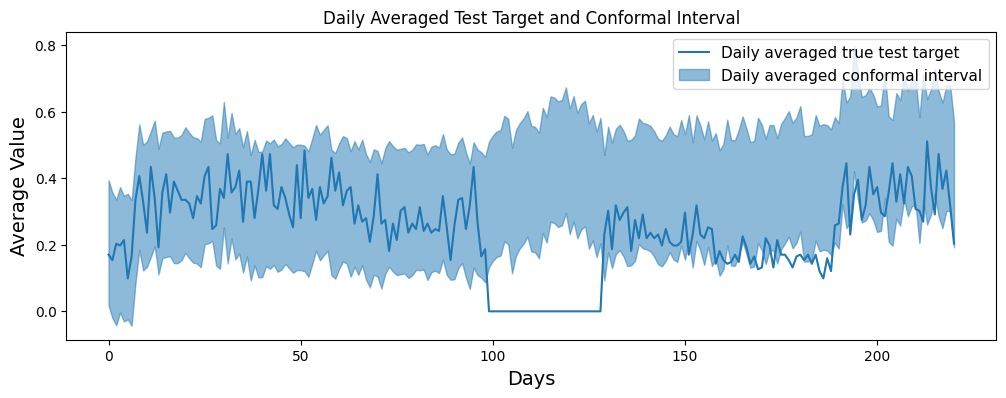

In [324]:
def daily_avg(x):
    return x

daily_avg_test = daily_avg(y_test.values)
n_days = daily_avg_test.shape[0]

plt.figure(figsize=(12, 4)) 
plt.plot(daily_avg_test, label="Daily averaged true test target")

plt.fill_between(
    np.arange(n_days),
    *daily_avg(conformal_intervals).T,
    alpha=0.5,
    color="C0",
    label="Daily averaged conformal interval",
)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Average Value", fontsize=14)
plt.legend(fontsize=11, loc="upper right")
plt.title("Daily Averaged Test Target and Conformal Interval")
plt.show()


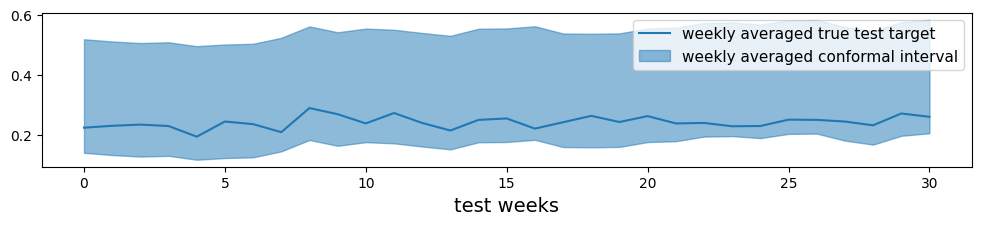

In [310]:
def weakly_avg(x):
    s = x.shape[0] // 7
    x = x[: s * 7]
    return x.reshape(7, s, *x.shape[1:]).mean(0)


weekly_avg_test = weakly_avg(y_test.values)
n_weeks = weekly_avg_test.shape[0]

plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")
     


EnbPI with online feedback

In [325]:
batch_size = 1
conformal_intervals2 = np.zeros((len(y_test), 2))
for i in range(0, len(y_test), batch_size):
    if i == 0:
        conformal_intervals2[:batch_size], train_residuals = EnbPI().conformal_interval(
            bootstrap_indices=bs_indices,
            bootstrap_train_preds=bs_train_preds,
            bootstrap_test_preds=bs_test_preds[:, :batch_size],
            train_targets=y_train.values,
            error=0.05,
            return_residuals=True,
        )
    else:
        (
            conformal_intervals2[i : i + batch_size],
            train_residuals,
        ) = EnbPI().conformal_interval_from_residuals(
            train_residuals=train_residuals,
            bootstrap_new_train_preds=bs_test_preds[:, i - batch_size : i],
            bootstrap_new_test_preds=bs_test_preds[:, i : i + batch_size],
            new_train_targets=y_test.values[i - batch_size : i],
            error=0.05,
        )

Slično kao što je učinjeno gore, izračunavamo postotak predviđanja i stvarnih ciljnih varijabli testa koje padaju unutar konformalnih intervala. Ponovno je dobro vidjeti da svi konformalni intervali uključuju točkaste predikcije. 

In [326]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, y_test.values)}."
)

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.8506787419319153.


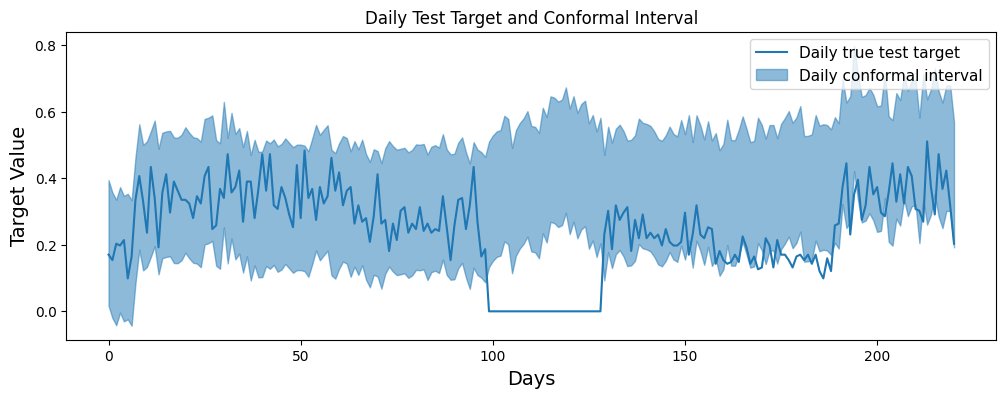

In [328]:
n_days = len(y_test.values)  

plt.figure(figsize=(12, 4))  
plt.plot(y_test.values, label="Daily true test target")

plt.fill_between(
    np.arange(n_days),
    conformal_intervals[:, 0], 
    conformal_intervals[:, 1],  
    alpha=0.5,
    color="C0",
    label="Daily conformal interval",
)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Target Value", fontsize=14)
plt.legend(fontsize=11, loc="upper right")
plt.title("Daily Test Target and Conformal Interval")
plt.show()


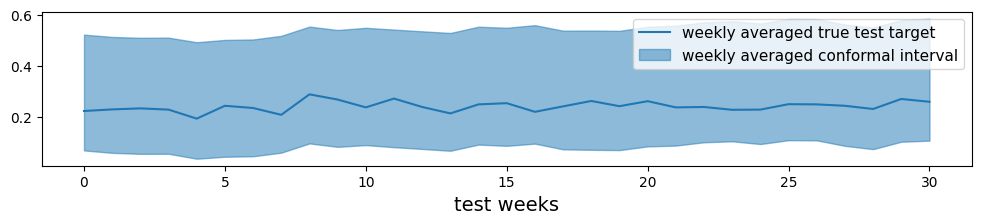

In [313]:
plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals2).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

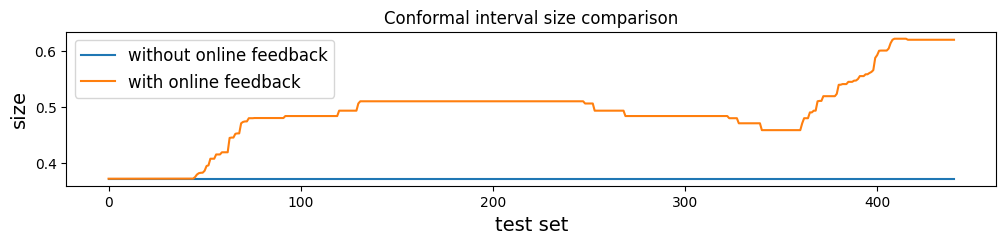

In [318]:
# The following plot compares the size of the intervals without and with online feedback.
plt.figure(figsize=(12, 2))
plt.title("Conformal interval size comparison")
plt.plot(np.diff(conformal_intervals), label="without online feedback")
plt.plot(np.diff(conformal_intervals2), label="with online feedback")
plt.xlabel("test set", fontsize=14)
plt.ylabel("size", fontsize=14)
plt.legend(fontsize=12)

#### Resort Hotel

In [375]:
y = daily_arrival_resort_data['broj_dolazaka'] / daily_arrival_resort_data['broj_dolazaka'].max()
X = daily_arrival_resort_data.drop(columns=['broj_dolazaka'],axis="columns")
X_train, X_test = train_test_split(X, test_size=0.4, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.4, shuffle=False)

In [376]:
n_bs_samples = 40
bs_indices, bs_train_data = DataFrameBootstrapper(n_samples=n_bs_samples)(
    X_train, y_train
)
  

In [377]:
bs_indices.shape

(40, 478)

In [378]:
X_train.shape

(478, 11)

In [379]:
len(bs_train_data)

40

In [380]:
bs_train_data[0][0][0:2]

,prosjecna_cijena_po_osobi,tempmax,tempmin,temp,precip,icon,holiday,workingday,year,month,day
454,72.471794,24.6,16.1,21.1,0.0,clear-day,False,False,2016,9,24
23,81.305253,31.3,22.2,25.8,0.0,clear-day,False,True,2015,7,24


In [381]:
# Get a boolean series where True indicates the index is duplicated
duplicate_indices = bs_train_data[0][0].index.duplicated(keep=False)

# Print the duplicated indices
print(bs_train_data[0][0].index[duplicate_indices])

Index([454, 336, 177, 416,  31, 301, 379, 234, 444, 177,
       ...
       436, 408, 245, 294,  44, 261, 371,  33,   7,  80],
      dtype='int64', length=300)


In [382]:
bs_train_data[0][0].loc[bs_train_data[0][0].index[duplicate_indices][0]]

,prosjecna_cijena_po_osobi,tempmax,tempmin,temp,precip,icon,holiday,workingday,year,month,day
454,72.471794,24.6,16.1,21.1,0.0,clear-day,False,False,2016,9,24
454,72.471794,24.6,16.1,21.1,0.0,clear-day,False,False,2016,9,24


In [387]:
categorical_columns = ['icon','holiday','workingday']
categories = [
   ['partly-cloudy-day', 'clear-day', 'rain', 'cloudy', 'wind'],
   [False, True],
   [False, True],
   ]

In [388]:
ordinal_encoder = OrdinalEncoder(categories=categories)

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns
    ),
).set_output(transform="pandas")

In [389]:
bs_train_preds = np.zeros((n_bs_samples, X_train.shape[0]))
bs_test_preds = np.zeros((n_bs_samples, X_test.shape[0]))
for i, batch in enumerate(bs_train_data):
    gbrt_pipeline.fit(*batch)
    bs_train_preds[i] = gbrt_pipeline.predict(X_train)
    bs_test_preds[i] = gbrt_pipeline.predict(X_test)

In [390]:
conformal_intervals = EnbPI().conformal_interval(
    bootstrap_indices=bs_indices,
    bootstrap_train_preds=bs_train_preds,
    bootstrap_test_preds=bs_test_preds,
    train_targets=y_train.values,
    error=0.05,
)

In [391]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, y_test.values)}."
)
print(f"Size of the conformal intervals: {np.diff(conformal_intervals)[0][0]}")

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.940625011920929.
Size of the conformal intervals: 0.5293644666671753


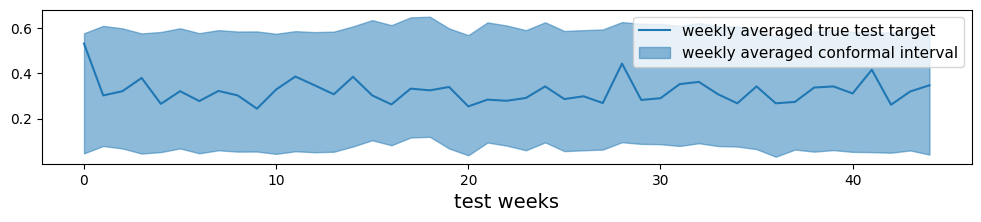

In [392]:
def weakly_avg(x):
    s = x.shape[0] // 7
    x = x[: s * 7]
    return x.reshape(7, s, *x.shape[1:]).mean(0)


weekly_avg_test = weakly_avg(y_test.values)
n_weeks = weekly_avg_test.shape[0]

plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")
     


EnbPI with online feedback

In [393]:
batch_size = 1
conformal_intervals2 = np.zeros((len(y_test), 2))
for i in range(0, len(y_test), batch_size):
    if i == 0:
        conformal_intervals2[:batch_size], train_residuals = EnbPI().conformal_interval(
            bootstrap_indices=bs_indices,
            bootstrap_train_preds=bs_train_preds,
            bootstrap_test_preds=bs_test_preds[:, :batch_size],
            train_targets=y_train.values,
            error=0.05,
            return_residuals=True,
        )
    else:
        (
            conformal_intervals2[i : i + batch_size],
            train_residuals,
        ) = EnbPI().conformal_interval_from_residuals(
            train_residuals=train_residuals,
            bootstrap_new_train_preds=bs_test_preds[:, i - batch_size : i],
            bootstrap_new_test_preds=bs_test_preds[:, i : i + batch_size],
            new_train_targets=y_test.values[i - batch_size : i],
            error=0.05,
        )

In [394]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, y_test.values)}."
)

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.956250011920929.


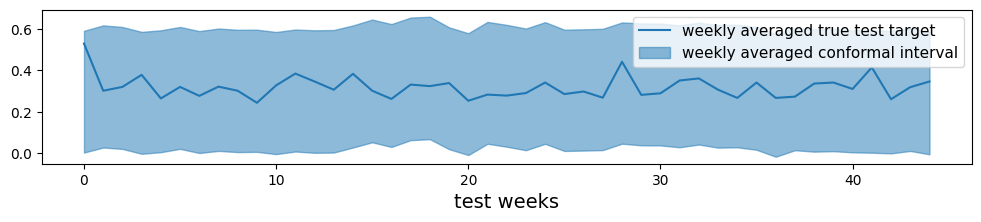

In [395]:
plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals2).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

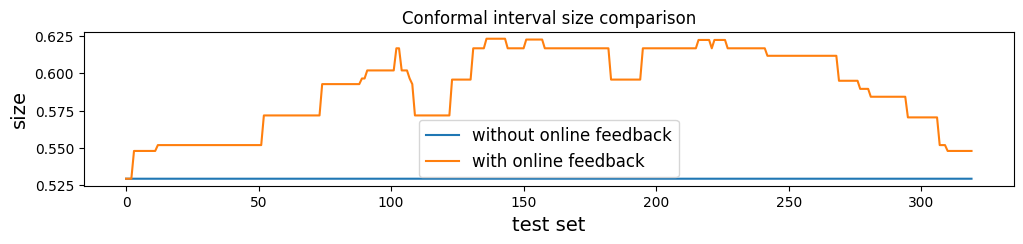

In [396]:
# The following plot compares the size of the intervals without and with online feedback.
plt.figure(figsize=(12, 2))
plt.title("Conformal interval size comparison")
plt.plot(np.diff(conformal_intervals), label="without online feedback")
plt.plot(np.diff(conformal_intervals2), label="with online feedback")
plt.xlabel("test set", fontsize=14)
plt.ylabel("size", fontsize=14)
plt.legend(fontsize=12)

### Modeliranje ukupnog broja gostiju u hotelu

#### City Hotel

In [330]:
daily_city_occupancy_data['month'] = daily_city_occupancy_data['month'].astype('category')
daily_city_occupancy_data['day'] = daily_city_occupancy_data['day'].astype('category')
daily_city_occupancy_data['year'] = daily_city_occupancy_data['year'].astype('category')

In [333]:
y = daily_city_occupancy_data['ukupno_gostiju'] / daily_city_occupancy_data['ukupno_gostiju'].max()
X = daily_city_occupancy_data.drop(columns=['ukupno_gostiju'],axis="columns")
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

In [345]:
n_bs_samples = 20
bs_indices, bs_train_data = DataFrameBootstrapper(n_samples=n_bs_samples)(
    X_train, y_train
)
  

In [346]:
bs_indices.shape

(20, 779)

In [347]:
X_train.shape

(779, 11)

In [348]:
# Get a boolean series where True indicates the index is duplicated
duplicate_indices = bs_train_data[0][0].index.duplicated(keep=False)

# Print the duplicated indices
print(bs_train_data[0][0].index[duplicate_indices])

Index([115, 470, 386, 536,  53, 313, 385,  89, 358, 688,
       ...
       637, 551, 419, 149, 341, 566, 327, 296, 365, 402],
      dtype='int64', length=486)


In [349]:
categorical_columns = ['icon','holiday','workingday','year','month','day']
categories = [
   ['clear-day', 'partly-cloudy-day', 'rain', 'cloudy'],
   [False, True],
   [False, True],
   [2015,2016,2017],
   [1,2,3,4,5,6,7,8,9,10,11,12],
   [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
   ]

In [350]:
ordinal_encoder = OrdinalEncoder(categories=categories)

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns
    ),
).set_output(transform="pandas")

In [351]:
bs_train_preds = np.zeros((n_bs_samples, X_train.shape[0]))
bs_test_preds = np.zeros((n_bs_samples, X_test.shape[0]))
for i, batch in enumerate(bs_train_data):
    gbrt_pipeline.fit(*batch)
    bs_train_preds[i] = gbrt_pipeline.predict(X_train)
    bs_test_preds[i] = gbrt_pipeline.predict(X_test)

In [352]:
conformal_intervals = EnbPI().conformal_interval(
    bootstrap_indices=bs_indices,
    bootstrap_train_preds=bs_train_preds,
    bootstrap_test_preds=bs_test_preds,
    train_targets=y_train.values,
    error=0.05,
)

In [353]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, y_test.values)}."
)
print(f"Size of the conformal intervals: {np.diff(conformal_intervals)[0][0]}")

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.49230772256851196.
Size of the conformal intervals: 0.22669252753257751


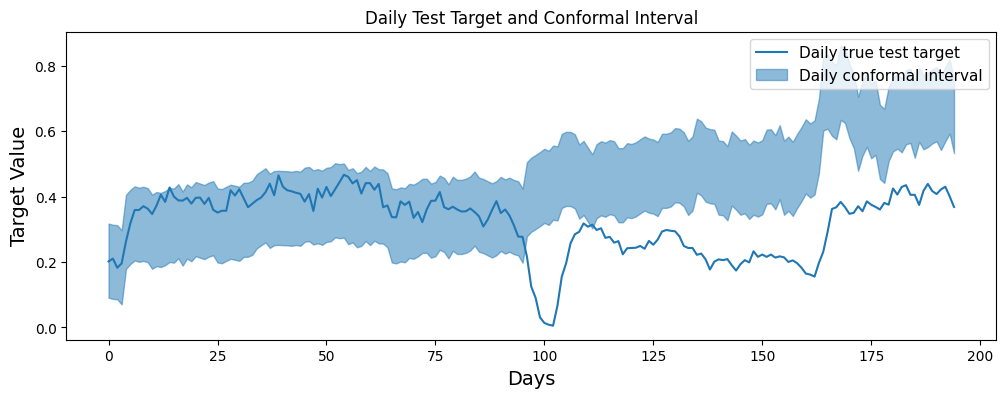

In [355]:
n_days = len(y_test.values) 

plt.figure(figsize=(12, 4)) 
plt.plot(y_test.values, label="Daily true test target")

plt.fill_between(
    np.arange(n_days),
    conformal_intervals[:, 0],  
    conformal_intervals[:, 1],  
    alpha=0.5,
    color="C0",
    label="Daily conformal interval",
)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Target Value", fontsize=14)
plt.legend(fontsize=11, loc="upper right")
plt.title("Daily Test Target and Conformal Interval")
plt.show()


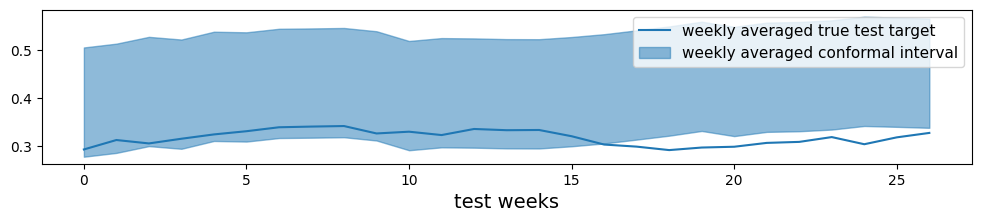

In [356]:
def weakly_avg(x):
    s = x.shape[0] // 7
    x = x[: s * 7]
    return x.reshape(7, s, *x.shape[1:]).mean(0)


weekly_avg_test = weakly_avg(y_test.values)
n_weeks = weekly_avg_test.shape[0]

plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")
     


EnbPI with online feedback

In [357]:
batch_size = 1
conformal_intervals2 = np.zeros((len(y_test), 2))
for i in range(0, len(y_test), batch_size):
    if i == 0:
        conformal_intervals2[:batch_size], train_residuals = EnbPI().conformal_interval(
            bootstrap_indices=bs_indices,
            bootstrap_train_preds=bs_train_preds,
            bootstrap_test_preds=bs_test_preds[:, :batch_size],
            train_targets=y_train.values,
            error=0.05,
            return_residuals=True,
        )
    else:
        (
            conformal_intervals2[i : i + batch_size],
            train_residuals,
        ) = EnbPI().conformal_interval_from_residuals(
            train_residuals=train_residuals,
            bootstrap_new_train_preds=bs_test_preds[:, i - batch_size : i],
            bootstrap_new_test_preds=bs_test_preds[:, i : i + batch_size],
            new_train_targets=y_test.values[i - batch_size : i],
            error=0.05,
        )

Similarly as done above, we compute the percentage of predictions and true test targets falling within the conformal intervals. Again, it is good to see that all conformal intervals include the point predictions. Also, the percentage of intervals containing the true targets increased to around 83%, getting closer to the desired coverage of 95%.

In [358]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, y_test.values)}."
)

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.620512843132019.


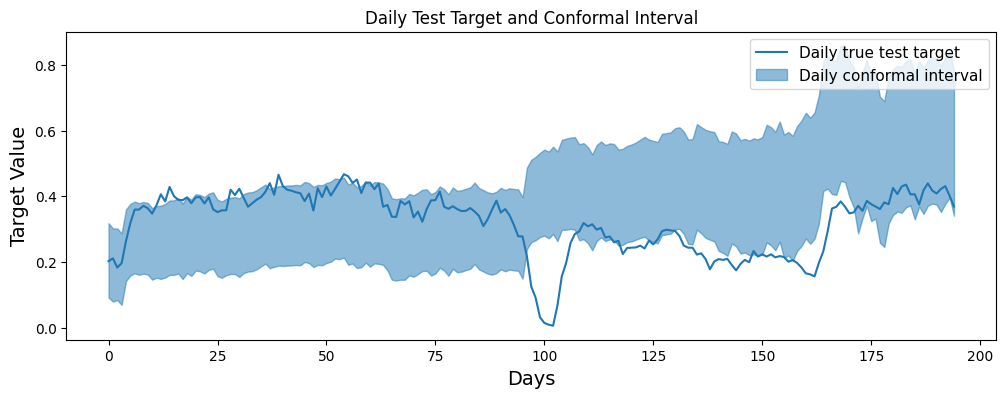

: 

In [360]:
n_days = len(y_test.values) 

plt.figure(figsize=(12, 4)) 
plt.plot(y_test.values, label="Daily true test target")

plt.fill_between(
    np.arange(n_days),
    conformal_intervals2[:, 0], 
    conformal_intervals2[:, 1],  
    alpha=0.5,
    color="C0",
    label="Daily conformal interval",
)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Target Value", fontsize=14)
plt.legend(fontsize=11, loc="upper right")
plt.title("Daily Test Target and Conformal Interval")
plt.show()


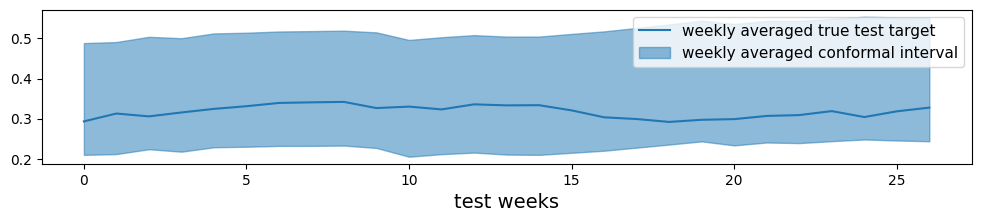

In [359]:
plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals2).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

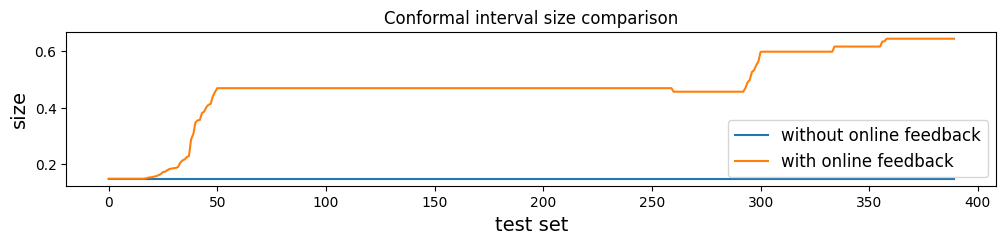

In [531]:
# The following plot compares the size of the intervals without and with online feedback.
plt.figure(figsize=(12, 2))
plt.title("Conformal interval size comparison")
plt.plot(np.diff(conformal_intervals), label="without online feedback")
plt.plot(np.diff(conformal_intervals2), label="with online feedback")
plt.xlabel("test set", fontsize=14)
plt.ylabel("size", fontsize=14)
plt.legend(fontsize=12)

#### Resort Hotel

In [533]:
y = daily_resort_occupancy_data['ukupno_gostiju'] / daily_resort_occupancy_data['ukupno_gostiju'].max()
X = daily_resort_occupancy_data.drop(columns=['ukupno_gostiju'],axis="columns")
X_train, X_test = train_test_split(X, test_size=0.4, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.4, shuffle=False)

In [534]:
n_bs_samples = 40
bs_indices, bs_train_data = DataFrameBootstrapper(n_samples=n_bs_samples)(
    X_train, y_train
)
  

In [535]:
bs_train_data[0][0][0:2]

,prosjecna_cijena_po_osobi,tempmax,tempmin,temp,precip,icon,holiday,workingday,year,month,day
180,45.537669,19.0,15.5,17.9,24.7,rain,False,True,2015,12,28
475,52.399722,20.3,11.9,16.8,0.0,partly-cloudy-day,False,False,2016,10,15


In [536]:
categorical_columns = ['icon','holiday','workingday']
categories = [
   ['partly-cloudy-day', 'clear-day', 'rain', 'cloudy', 'wind'],
   [False, True],
   [False, True],
   ]

In [537]:
ordinal_encoder = OrdinalEncoder(categories=categories)

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns
    ),
).set_output(transform="pandas")

In [538]:
bs_train_preds = np.zeros((n_bs_samples, X_train.shape[0]))
bs_test_preds = np.zeros((n_bs_samples, X_test.shape[0]))
for i, batch in enumerate(bs_train_data):
    gbrt_pipeline.fit(*batch)
    bs_train_preds[i] = gbrt_pipeline.predict(X_train)
    bs_test_preds[i] = gbrt_pipeline.predict(X_test)

In [539]:
conformal_intervals = EnbPI().conformal_interval(
    bootstrap_indices=bs_indices,
    bootstrap_train_preds=bs_train_preds,
    bootstrap_test_preds=bs_test_preds,
    train_targets=y_train.values,
    error=0.05,
)

In [540]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, y_test.values)}."
)
print(f"Size of the conformal intervals: {np.diff(conformal_intervals)[0][0]}")

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.8615384697914124.
Size of the conformal intervals: 0.39440369606018066


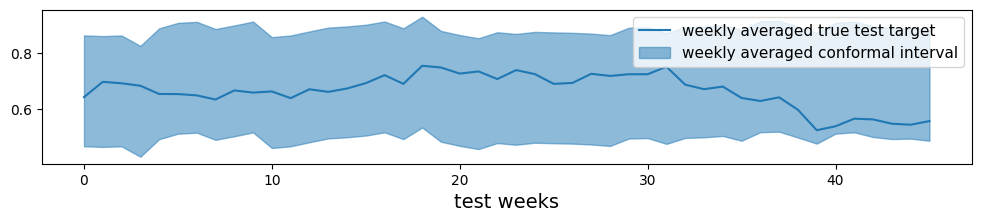

In [541]:
def weakly_avg(x):
    s = x.shape[0] // 7
    x = x[: s * 7]
    return x.reshape(7, s, *x.shape[1:]).mean(0)


weekly_avg_test = weakly_avg(y_test.values)
n_weeks = weekly_avg_test.shape[0]

plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")
     


EnbPI with online feedback

In [543]:
batch_size = 1
conformal_intervals2 = np.zeros((len(y_test), 2))
for i in range(0, len(y_test), batch_size):
    if i == 0:
        conformal_intervals2[:batch_size], train_residuals = EnbPI().conformal_interval(
            bootstrap_indices=bs_indices,
            bootstrap_train_preds=bs_train_preds,
            bootstrap_test_preds=bs_test_preds[:, :batch_size],
            train_targets=y_train.values,
            error=0.05,
            return_residuals=True,
        )
    else:
        (
            conformal_intervals2[i : i + batch_size],
            train_residuals,
        ) = EnbPI().conformal_interval_from_residuals(
            train_residuals=train_residuals,
            bootstrap_new_train_preds=bs_test_preds[:, i - batch_size : i],
            bootstrap_new_test_preds=bs_test_preds[:, i : i + batch_size],
            new_train_targets=y_test.values[i - batch_size : i],
            error=0.05,
        )

In [544]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, y_test.values)}."
)

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.8769230842590332.


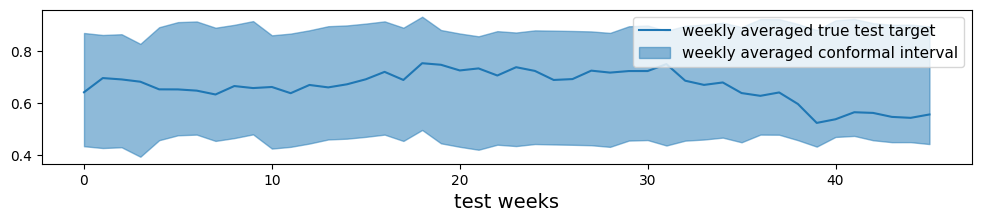

In [545]:
plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals2).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

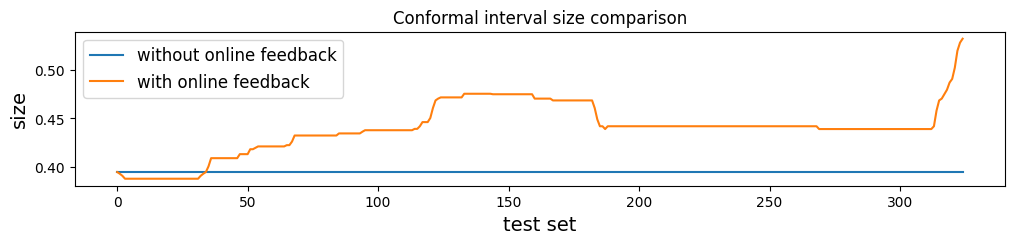

In [546]:
# The following plot compares the size of the intervals without and with online feedback.
plt.figure(figsize=(12, 2))
plt.title("Conformal interval size comparison")
plt.plot(np.diff(conformal_intervals), label="without online feedback")
plt.plot(np.diff(conformal_intervals2), label="with online feedback")
plt.xlabel("test set", fontsize=14)
plt.ylabel("size", fontsize=14)
plt.legend(fontsize=12)